# Notebook de inferencia — **3DCNN** (modelo alterno)

Este cuaderno ejecuta **inferencias reproducibles** para generar los artefactos escenciales cuantitativos y gráficos:
- Predicciones por instancia (\`y_true\`, \`y_pred\`, \`y_score\`).
- Métricas puntuales (F1, accuracy, precision, recall, AUC, sensibilidad, especificidad) **+ IC 95% por bootstrap (B=1000, semilla=42)**.
- **Matriz de confusión** (PNG) y **Curva ROC** (PNG, con IC opcional por bootstrap).
- **Eficiencia**: latencia/FPS y tamaño del modelo.
- (**Opcional**) **McNemar** al comparar con el modelo propuesto si se provee \`preds_propuesto.csv\`.

⚠️ **Requisitos**: tener disponibles los módulos del proyecto en el \`PYTHONPATH\` o en el directorio de trabajo:  
- `cnn3d.py` (arquitectura alterna),  
- `rwf_npy_dataset.py` (dataset de inferencia),  
- `tensor_transform.py` (transformaciones/normalización),  
- `config_inference_altern.yaml` (configuración inferencia),  
- `model_cnn3d.pth` (checkpoint del modelo alterno).



In [2]:
# ==============================
# 1) Importaciones y utilidades
# ==============================
from __future__ import annotations
import os, json, math, time, random
from model.cnn3d import ViolenceDualStreamNet
from datasets.rwf_npy_dataset import RWFNpyDataset
from datasets.tensor_transform import TensorVideoTransforms
from utils.seed import set_seed
from torchinfo import summary
from typing import Tuple, Dict, Any, List
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
from sklearn.metrics import (f1_score, accuracy_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, roc_curve)
from utils.config_loader import ConfigLoader
from dotenv import load_dotenv


dotenv_path = Path().resolve().parent.parent / ".env"
# Carga variables de entorno desde .env si existe
load_dotenv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
BASE_DIR = os.getcwd()
CONFIG_PATH = os.path.join(BASE_DIR,  "config", "config.yaml")
CONFIG_BEST_PATH = os.path.join(BASE_DIR, "config", "config_inference_altern.yaml")


In [4]:
def load_config() -> object:
    """
    Load configuration YAML, prioritizing best config if exists.

    Returns
    -------
    object
        Parsed config object.
    """
    path = CONFIG_BEST_PATH if os.path.exists(CONFIG_BEST_PATH) else CONFIG_PATH
    print(f"⚙️  Loading configuration from: {path}")
    return ConfigLoader(path).get()

In [5]:
config = load_config()

⚙️  Loading configuration from: f:\tesis_2025\violence_detection\Repositorio\DS3D-FGAttNET\src\config\config_inference_altern.yaml


In [6]:
# ======================================
# 2) Configuración de rutas y parámetros
# ======================================
CHECKPOINT_PATH = Path(config.inference.model_path)   # <-- ajusta si está en otra ruta
BATCH_SIZE = 8
NUM_WORKERS = 6
THRESHOLD = 0.5  # pre-especificado en §4.3.8
BOOTSTRAP_B = 1000
BOOTSTRAP_SEED = 42

print(CHECKPOINT_PATH.resolve())

F:\tesis_2025\violence_detection\Repositorio\DS3D-FGAttNET\src\inference\model\model_cnn3d.pth


In [7]:
# ===================================
# 3) Definición de funciones generales
# ===================================

def collect_npy_paths(base_path: str) -> Tuple[List[str], List[int]]:
    """
    Collect .npy file paths and their labels from dataset directories.

    Parameters
    ----------
    base_path : str
        Path to dataset split directory.

    Returns
    -------
    Tuple[List[str], List[int]]
        File paths and integer labels.
    """
    paths, labels = [], []
    for class_name, label in zip(["Fight", "NonFight"], [1, 0]):
        class_dir = os.path.join(base_path, class_name)
        if not os.path.exists(class_dir):
            continue
        for fname in sorted(os.listdir(class_dir)):
            if fname.endswith(".npy"):
                paths.append(os.path.join(class_dir, fname))
                labels.append(label)
    return paths, labels

def load_model(config:Any):
    model = ViolenceDualStreamNet(
    num_classes=config.model.num_classes,
    dropout=config.model.dropout,
    classifier_hidden=getattr(config.model, "classifier_hidden", 128)
)
    model_path = config.inference.model_path  # Debe existir el modelo .pth o .pt
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model
    
def prepare_test_suite(config:any):
    test_paths, test_labels = collect_npy_paths(os.path.join(config.dataset.root, "val"))

    test_dataset = RWFNpyDataset(
        test_paths,
        test_labels,
        transform=TensorVideoTransforms.from_config(config, mode="val"),  # val equivale a no aplicar augmentación
        normalize_global=getattr(config.dataset, "normalize_global", True),
        expected_shape=(5, 32, 224, 224)
    )
    set_seed(config.general.seed)
    return DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=(device.type=='cuda'))

In [8]:
plt.rcParams.update({
    'figure.dpi': 120,
    'savefig.dpi': 300,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

OUT_DIR = Path(config.inference.output_path)
OUT_DIR.mkdir(parents=True, exist_ok=True)

def save_json(obj: Any, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)


def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def binom_test_two_sided(k: int, n: int) -> float:
    """
    McNemar exact test (two-sided) via binomial test under H0: p=0.5.
    Returns p-value using a probability mass mirror approach.
    """
    from math import comb
    if n == 0:
        return 1.0
    # probability mass function for Bin(n, 0.5)
    pmf = lambda x: comb(n, x) * (0.5 ** n)
    # Two-sided: sum probabilities of outcomes with probability <= pmf(k)
    p_k = pmf(k)
    return float(sum(pmf(x) for x in range(0, n+1) if pmf(x) <= p_k))


In [9]:
# ===================================
# 4) Carga de modelo y checkpoint
# ===================================

model = load_model(config)
summary(model, input_size=(1, 5, 32, 224, 224), device=device.type)
model.eval()


ViolenceDualStreamNet(
  (rgb_stream): Sequential(
    (0): Separable3DConv(
      (spatial): Conv3d(3, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (temporal): Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activationRGB): ReLU(inplace=True)
      (activationFlow): ReLU(inplace=True)
    )
    (1): Separable3DConv(
      (spatial): Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (temporal): Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activationRGB): ReLU(inplace=True)
      (activationFlow): ReLU(inplace=True)
    )
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Separ

In [10]:

loader = prepare_test_suite(config)

In [12]:
print("len(dataset) =", len(loader.dataset))
try:
    b = next(iter(loader))
    if isinstance(b, (list, tuple)):
        print("batch lens =", len(b), "x.shape =", b[0].shape, "y.shape =", b[1].shape if len(b)>=2 else None)
    else:
        print("batch type =", type(b))
except StopIteration:
    print("NO HAY BATCHES (StopIteration)")

len(dataset) = 400
batch lens = 2 x.shape = torch.Size([8, 5, 32, 224, 224]) y.shape = torch.Size([8])


In [13]:
# ==================================
# 5) Bucle de inferencia y guardado
# ==================================
y_true_all, y_pred_all, y_score_all, ids_all = [], [], [], []
sigmoid = nn.Sigmoid()

use_amp = (device.type == 'cuda')
from torch.amp import autocast

with torch.no_grad():
    for batch in loader:
        # Se asume que el dataset retorna (video, label, id) o (video, label)
        if len(batch) == 3:
            x, y, ids = batch
        else:
            x, y = batch
            ids = [None] * x.shape[0]

        x = x.to(device, non_blocking=True)
        y = y.numpy().astype(int)
        with autocast(device_type='cuda', enabled=use_amp):
            logits = model(x)
        if logits.shape[-1] == 1:
            # salida tipo logit binario
            probs_pos = sigmoid(logits).squeeze(-1).detach().cpu().numpy()
        else:
            # salida tipo 2 clases
            probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
            probs_pos = probs[:, 1]

        y_hat = (probs_pos >= THRESHOLD).astype(int)
        y_true_all.extend(y.tolist())
        y_pred_all.extend(y_hat.tolist())
        y_score_all.extend(probs_pos.tolist())
        ids_all.extend(ids)

y_true = np.array(y_true_all)
y_pred = np.array(y_pred_all)
y_score = np.array(y_score_all)

np.savez(OUT_DIR / 'preds_altern.npz', y_true=y_true, y_pred=y_pred, y_score=y_score, ids=np.array(ids_all, dtype=object))
import pandas as pd
df_preds = pd.DataFrame({'id': ids_all, 'y_true': y_true, 'y_pred': y_pred, 'y_score': y_score})
df_preds.to_csv(OUT_DIR / 'preds_altern.csv', index=False)
print("Guardado:", (OUT_DIR / 'preds_altern.csv').resolve())


Guardado: F:\tesis_2025\violence_detection\Repositorio\DS3D-FGAttNET\outputs\predictions\altern\preds_altern.csv


In [ ]:
# ==============================================
# 6) Métricas puntuales + IC 95% (bootstrap)
# ==============================================
def specificity_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

def metrics_pointwise(y_true, y_pred, y_score):
    # y_pred debe ser etiquetas binarias (0/1); y_score probabilidad del positivo
    res = {}
    res['f1'] = float(f1_score(y_true, y_pred, zero_division=0))
    res['accuracy'] = float(accuracy_score(y_true, y_pred))
    res['precision'] = float(precision_score(y_true, y_pred, zero_division=0))
    res['recall'] = float(recall_score(y_true, y_pred, zero_division=0))
    # especificidad = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    res['specificity'] = float(spec)
    # AUC: si y_score es constante o no suficiente variedad, capturar excepción
    try:
        res['auc'] = float(roc_auc_score(y_true, y_score))
    except Exception:
        res['auc'] = float('nan')
    return res

def bootstrap_ci_stratified(y_true: np.ndarray, y_pred: np.ndarray, y_score: np.ndarray,
                            B: int = 1000, seed: int = 42) -> dict[str, tuple[float, float]]:
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred); y_score = np.asarray(y_score)

    idx_pos = np.where(y_true == 1)[0]
    idx_neg = np.where(y_true == 0)[0]
    n_pos, n_neg = len(idx_pos), len(idx_neg)

    vals = {k: [] for k in ['f1','accuracy','precision','recall','auc','specificity']}
    for _ in range(B):
        # muestreo con reemplazo por estrato
        s_pos = rng.integers(0, n_pos, size=n_pos)
        s_neg = rng.integers(0, n_neg, size=n_neg)
        idx_b = np.concatenate([idx_pos[s_pos], idx_neg[s_neg]])

        yt = y_true[idx_b]
        yp = y_pred[idx_b]
        ys = y_score[idx_b]

        m = metrics_pointwise(yt, yp, ys)
        for k, v in m.items():
            vals[k].append(v)

    ci = {}
    for k, arr in vals.items():
        lo, hi = np.percentile(arr, [2.5, 97.5])
        ci[k] = (float(lo), float(hi))
    return ci

m_point = metrics_pointwise(y_true, y_pred, y_score)
m_ci = bootstrap_ci_stratified(y_true, y_pred, y_score, B=BOOTSTRAP_B, seed=BOOTSTRAP_SEED)

print("Métricas puntuales:")
for k, v in m_point.items():
    print(f"  {k}: {v:.5f}")
print("\nIC 95% (bootstrap):")
for k, (lo, hi) in m_ci.items():
    print(f"  {k}: [{lo:.5f}, {hi:.5f}]")

df_metrics = pd.DataFrame({
    'metric': list(m_point.keys()),
    'point_estimate': [m_point[k] for k in m_point.keys()],
    'ci_low': [m_ci[k][0] for k in m_point.keys()],
    'ci_high': [m_ci[k][1] for k in m_point.keys()],
})
df_metrics.to_csv(OUT_DIR / 'metrics_altern.csv', index=False)
df_metrics


Métricas puntuales:
  f1: 0.80612
  accuracy: 0.81000
  precision: 0.82292
  recall: 0.79000
  auc: 0.87256
  specificity: 0.83000

IC 95% (bootstrap):
  f1: [0.75862, 0.84800]
  accuracy: [0.76750, 0.85000]
  precision: [0.76883, 0.87846]
  recall: [0.72906, 0.84467]
  auc: [0.83480, 0.90515]
  specificity: [0.77831, 0.87982]


,metric,point_estimate,ci_low,ci_high
0,f1,0.806122,0.758621,0.848001
1,accuracy,0.810000,0.767500,0.850000
2,precision,0.822917,0.768834,0.878458
3,recall,0.790000,0.729062,0.844670
4,auc,0.872563,0.834799,0.905150
5,specificity,0.830000,0.778311,0.879818


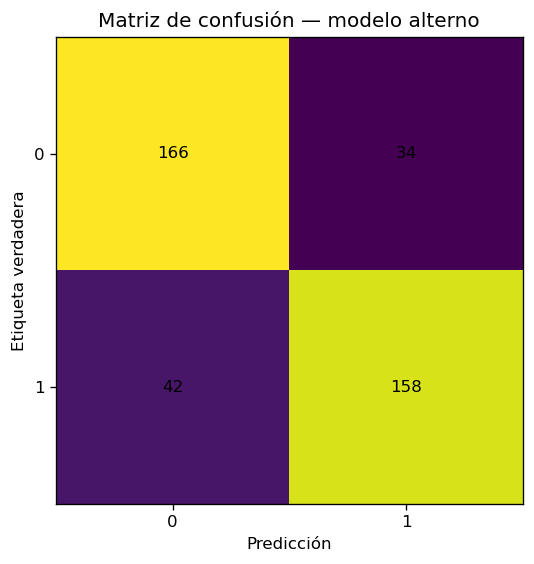

Guardado: F:\tesis_2025\violence_detection\Repositorio\DS3D-FGAttNET\outputs\predictions\altern\cm_altern.png


In [15]:
# ============================
# 7) Matriz de confusión (PNG)
# ============================
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
fig = plt.figure()
ax = plt.gca()
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Matriz de confusión — modelo alterno')
ax.set_xlabel('Predicción')
ax.set_ylabel('Etiqueta verdadera')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center')
fig.tight_layout()
path_cm = OUT_DIR / 'cm_altern.png'
plt.savefig(path_cm)
plt.show()
print('Guardado:', path_cm.resolve())


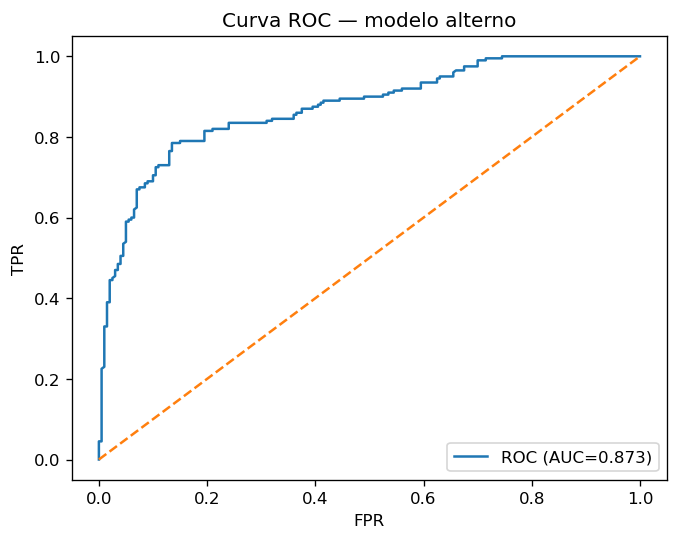

Guardado: F:\tesis_2025\violence_detection\Repositorio\DS3D-FGAttNET\outputs\predictions\altern\roc_alterno.png


In [ ]:
# ======================
# 8) Curva ROC (PNG)
# ======================
rng = np.random.default_rng(BOOTSTRAP_SEED)

fpr, tpr, thr = roc_curve(y_true, y_score)
auc_val = roc_auc_score(y_true, y_score)

fpr_grid = np.linspace(0, 1, 201)
tprs = []

idx_pos = np.where(np.array(y_true) == 1)[0]
idx_neg = np.where(np.array(y_true) == 0)[0]
n_pos, n_neg = len(idx_pos), len(idx_neg)

for _ in range(BOOTSTRAP_B):
    s_pos = rng.integers(0, n_pos, size=n_pos)
    s_neg = rng.integers(0, n_neg, size=n_neg)
    idx_b = np.concatenate([idx_pos[s_pos], idx_neg[s_neg]])

    yt = np.array(y_true)[idx_b]
    ys = np.array(y_score)[idx_b]

    fpr_b, tpr_b, _ = roc_curve(yt, ys)
    tpr_interp = np.interp(fpr_grid, fpr_b, tpr_b, left=0, right=1)
    tprs.append(tpr_interp)

tprs = np.array(tprs)
tpr_lo = np.percentile(tprs, 2.5, axis=0)
tpr_hi = np.percentile(tprs, 97.5, axis=0)

fig = plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_val:.3f})')
plt.fill_between(fpr_grid, tpr_lo, tpr_hi, color='blue', alpha=0.2, label='IC95% bootstrap')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC — modelo alterno')
plt.legend(loc='lower right')
path_roc = OUT_DIR / 'roc_alterno.png'
plt.savefig(path_roc)
plt.show()
print('Guardado:', path_roc.resolve())


In [ ]:
# =================================================
# 9) Eficiencia: latencia/FPS y tamaño del modelo
# =================================================
def measure_efficiency(model: nn.Module, loader: DataLoader, n_batches: int = 20) -> Dict[str, float]:
    model.eval()
    # Warm-up
    with torch.no_grad():
        it = iter(loader)
        for _ in range(10):
            try:
                x, *_ = next(it)
            except StopIteration:
                break
            x = x.to(device, non_blocking=True)
            _ = model(x)
            if device.type == 'cuda':
                torch.cuda.synchronize()
    # Measure
    times = []
    with torch.no_grad():
        it = iter(loader)
        for i in range(n_batches):
            try:
                x, *_ = next(it)
            except StopIteration:
                break
            x = x.to(device, non_blocking=True)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            t0 = time.time()
            _ = model(x)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            t1 = time.time()
            times.append(t1 - t0)
    if len(times) == 0:
        return {'latency_ms_per_batch': None, 'fps_clips_per_s': None}
    latency_ms = float(np.mean(times) * 1000.0)
    bs = loader.batch_size if hasattr(loader, 'batch_size') else 1
    fps = float((bs) / np.mean(times))
    return {'latency_ms_per_batch': latency_ms, 'fps_clips_per_s': fps}

eff = measure_efficiency(model, loader, n_batches=20)
print(eff)

def sizeof_model_mb(model: nn.Module) -> float:
    total = 0
    for p in model.parameters():
        total += p.nelement() * p.element_size()
    return total / (1024**2)

size_mb = sizeof_model_mb(model)
summary_eff = {'latency_ms_per_batch': eff['latency_ms_per_batch'], 'fps_clips_per_s': eff['fps_clips_per_s'], 'model_size_mb': size_mb}
save_json(summary_eff, OUT_DIR / 'efficiency_alterno.json')
summary_eff


{'latency_ms_per_batch': 294.761061668396, 'fps_clips_per_s': 27.14062690207006}


{'latency_ms_per_batch': 294.761061668396,
 'fps_clips_per_s': 27.14062690207006,
 'model_size_mb': 1.0880813598632812}


### Curva PR (opcional, dataset balanceado)
Calcula y exporta **Precision–Recall** y **AUPRC**


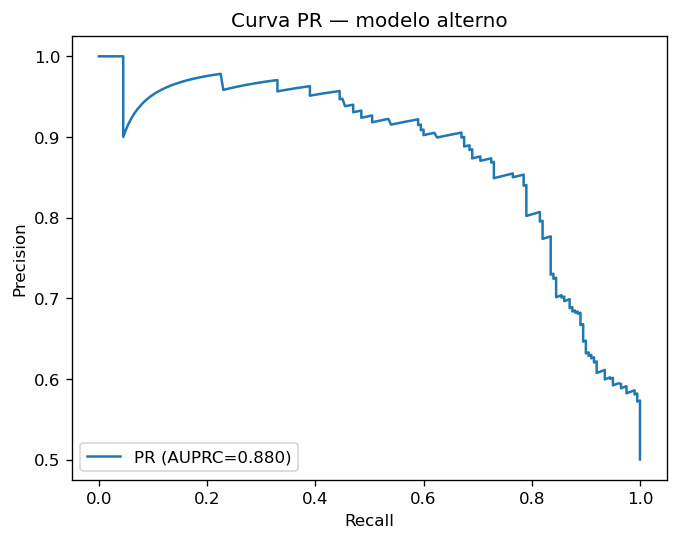

Guardado: F:\tesis_2025\violence_detection\Repositorio\DS3D-FGAttNET\outputs\predictions\altern\pr_alterno.png | AUPRC = 0.8802657098042979


In [18]:

from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

prec, rec, thr_pr = precision_recall_curve(y_true, y_score)
auprc = average_precision_score(y_true, y_score)

fig = plt.figure()
plt.plot(rec, prec, label=f'PR (AUPRC={auprc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva PR — modelo alterno')
plt.legend(loc='lower left')
path_pr = OUT_DIR / 'pr_alterno.png'
plt.savefig(path_pr)
plt.show()
print('Guardado:', path_pr.resolve(), '| AUPRC =', auprc)



### Banda de confianza ROC (bootstrap, IC 95 %)
Genera una **banda de confianza** alrededor de la curva ROC usando bootstrap (B=1000, semilla=42).


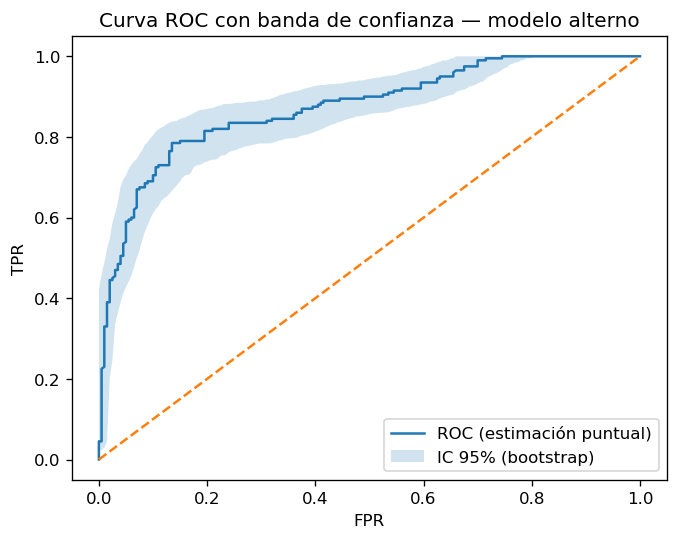

Guardado: F:\tesis_2025\violence_detection\Repositorio\DS3D-FGAttNET\outputs\predictions\altern\roc_alterno_ci.png


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
rng = np.random.default_rng(BOOTSTRAP_SEED)
grid_fpr = np.linspace(0, 1, 201)

tprs = []
n = len(y_true)
for _ in range(BOOTSTRAP_B):
    idx = rng.integers(0, n, size=n)
    fpr_b, tpr_b, _ = roc_curve(y_true[idx], y_score[idx])
    tpr_interp = np.interp(grid_fpr, fpr_b, tpr_b, left=0, right=1)
    tprs.append(tpr_interp)
tprs = np.array(tprs)
lo = np.percentile(tprs, 2.5, axis=0)
hi = np.percentile(tprs, 97.5, axis=0)

fig = plt.figure()
plt.plot(fpr, tpr, label='ROC (estimación puntual)')
plt.fill_between(grid_fpr, lo, hi, alpha=0.2, label='IC 95% (bootstrap)')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC con banda de confianza — modelo alterno')
plt.legend(loc='lower right')
path_roc_ci = OUT_DIR / 'roc_alterno_ci.png'
plt.savefig(path_roc_ci)
plt.show()
print('Guardado:', path_roc_ci.resolve())



### Classification report (texto y CSV)



In [20]:

from sklearn.metrics import classification_report
import pandas as pd

report_txt = classification_report(y_true, y_pred, target_names=['NonViolence','Violence'], digits=4, zero_division=0)
with open(OUT_DIR / 'classification_report_alterno.txt', 'w', encoding='utf-8') as f:
    f.write(report_txt)

# convertir a dataframe
rep_dict = classification_report(y_true, y_pred, target_names=['NonViolence','Violence'], output_dict=True, zero_division=0)
df_rep = pd.DataFrame(rep_dict).transpose()
df_rep.to_csv(OUT_DIR / 'classification_report_alterno.csv', index=True)
print('Guardado: classification_report_alterno.txt / .csv')


Guardado: classification_report_alterno.txt / .csv



### Matriz de confusión normalizada (por filas)



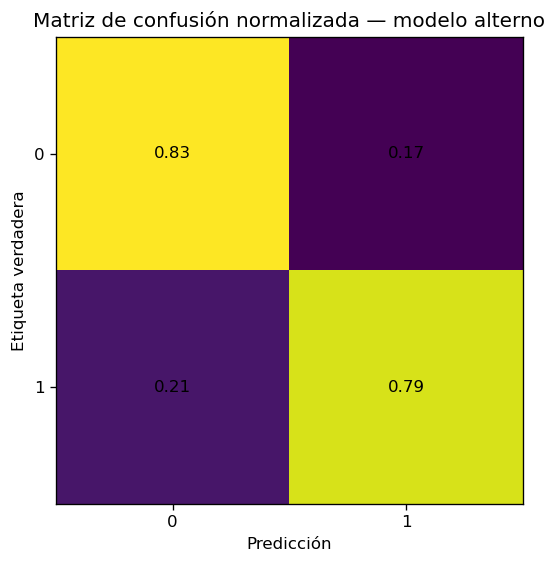

Guardado: F:\tesis_2025\violence_detection\Repositorio\DS3D-FGAttNET\outputs\predictions\altern\cm_alterno_normalizada.png


In [21]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

fig = plt.figure()
ax = plt.gca()
im = ax.imshow(cm_norm, interpolation='nearest')
ax.set_title('Matriz de confusión normalizada — modelo alterno')
ax.set_xlabel('Predicción')
ax.set_ylabel('Etiqueta verdadera')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm_norm[i, j]:.2f}", ha='center', va='center')
fig.tight_layout()
path_cmn = OUT_DIR / 'cm_alterno_normalizada.png'
plt.savefig(path_cmn)
plt.show()
print('Guardado:', path_cmn.resolve())
